<a href="https://colab.research.google.com/github/IsraelPeled/Image-Colorization/blob/main/GreyToColorCNN.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
! unzip -q "/content/drive/MyDrive/Deep Learning/GreyToColor/archive.zip" -d './'

#**Imports**

In [ ]:
import os
import numpy as np
import matplotlib.pyplot as plt
from PIL import Image
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision
import torchvision.transforms as transforms
from torchvision.io import read_image
from torch.utils.data import Dataset, DataLoader, random_split
from torchvision.datasets import ImageFolder
from tqdm.notebook import tqdm

In [ ]:
MANUAL_SEED = 42
BATCH_SIZE = 32
SHUFFLE = True
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(device)

cpu


#**Data Preparation**

In [ ]:
class LandscapeDataset(Dataset):
    def __init__(self, transform=None):
        self.dataroot = "./landscape Images"
        self.images = os.listdir(f'{self.dataroot}/color')
        self.transform = transform

    def __len__(self):
        return len(self.images)

    def __getitem__(self, idx):
        # Get image Paths
        img_path = self.images[idx]

        # Load the images
        color_img = read_image(f'{self.dataroot}/color/{img_path}') / 255
        gray_img = read_image(f'{self.dataroot}/gray/{img_path}') / 255

        if self.transform:
            color_img = self.transform(color_img)
            gray_img = self.transform(gray_img)

        return color_img, gray_img

In [ ]:
transform = transforms.Compose([
    transforms.Resize((150, 150), antialias=False),
])

dataset = LandscapeDataset(transform=transform)

train_set, val_set, test_set = random_split(dataset, [0.7, 0.15, 0.15], generator=torch.Generator().manual_seed(MANUAL_SEED))

trainloader = DataLoader(train_set, batch_size=BATCH_SIZE, shuffle=SHUFFLE)
valloader = DataLoader(val_set, batch_size=BATCH_SIZE, shuffle=SHUFFLE)
testloader = DataLoader(test_set, batch_size=BATCH_SIZE, shuffle=SHUFFLE)

In [ ]:
def show_images(color, gray):
    fig, axs = plt.subplots(5, 2, figsize=(15, 15))
    axs[0, 0].set_title('Grayscale')
    axs[0, 1].set_title('Color')
    for i in range(5):
        axs[i, 0].imshow(gray[i].permute(1,2,0), cmap='gray')
        axs[i, 0].axis('off')
        axs[i, 1].imshow(color[i].permute(1,2,0))
        axs[i, 1].axis('off')
    plt.show()

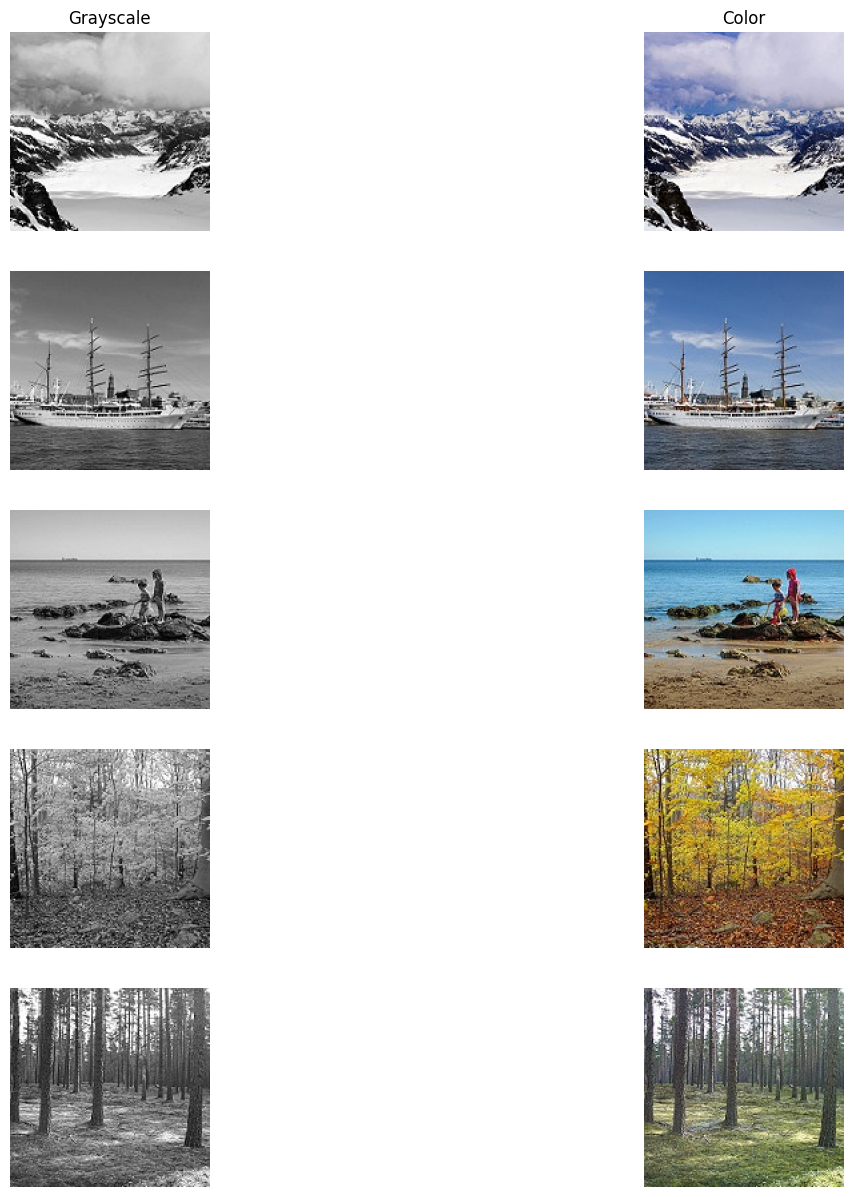

In [ ]:
color, gray = next(iter(trainloader))
show_images(color, gray)

#**Model Building:**

In [ ]:
EPOCHS = 10
LEARNING_RATE = 0.001

In [ ]:
class ColorAutoEncoder(nn.Module):
    def __init__(self):
        super().__init__()
        # Input shape: Bx1x150x150
        # Conv2d(in_channels, out_channels, kernel_size, stride, padding)

        self.down1 = nn.Conv2d(1, 64, 3, stride=2) # Bx64x74x74
        self.down2 = nn.Conv2d(64, 128, 3, stride=2, padding=1) # Bx128x37x37
        self.down3 = nn.Conv2d(128, 256, 3, stride=2, padding=1) # Bx256x19x29
        self.down4 = nn.Conv2d(256, 512, 3, stride=2, padding=1) # Bx512x10x10

        self.up1 = nn.ConvTranspose2d(512, 256, 3, stride=2, padding=1)
        self.up2 = nn.ConvTranspose2d(512, 128, 3, stride=2, padding=1)
        self.up3 = nn.ConvTranspose2d(256, 64, 3, stride=2, padding=1, output_padding=1)
        self.up4 = nn.ConvTranspose2d(128, 3, 3, stride=2, output_padding=1)

        self.relu = nn.ReLU()
        self.sigmoid = nn.Sigmoid()

    def forward(self, x):
        # Down sample
        d1 = self.relu(self.down1(x))
        d2 = self.relu(self.down2(d1))
        d3 = self.relu(self.down3(d2))
        d4 = self.relu(self.down4(d3))
        # Upsample
        u1 = self.relu(self.up1(d4))
        u2 = self.relu(self.up2(torch.cat((u1,d3), dim=1)))
        u3 = self.relu(self.up3(torch.cat((u2, d2), dim=1)))
        u4 = self.sigmoid(self.up4(torch.cat((u3,d1), dim=1)))

        return u4

#**Training:**

In [ ]:
model = ColorAutoEncoder().to(device)
total_params = sum(p.numel() for p in model.parameters() if p.requires_grad)
print(f"Total Number of trainable parameters of this model are: {total_params:,}")
print(f'\n{model}')

Total Number of trainable parameters of this model are: 3,470,659

ColorAutoEncoder(
  (down1): Conv2d(1, 64, kernel_size=(3, 3), stride=(2, 2))
  (down2): Conv2d(64, 128, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
  (down3): Conv2d(128, 256, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
  (down4): Conv2d(256, 512, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
  (up1): ConvTranspose2d(512, 256, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
  (up2): ConvTranspose2d(512, 128, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
  (up3): ConvTranspose2d(256, 64, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), output_padding=(1, 1))
  (up4): ConvTranspose2d(128, 3, kernel_size=(3, 3), stride=(2, 2), output_padding=(1, 1))
  (relu): ReLU()
  (sigmoid): Sigmoid()
)


In [ ]:
criterion = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=LEARNING_RATE)

In [ ]:
def train_loop(trainloader, model, criterion, optimizer):
    running_loss = 0.0
    for idx, (color_img, gray_img) in tqdm(enumerate(trainloader), total=len(trainloader)):
        color_img = color_img.to(device)
        gray_img = gray_img.to(device)

        predictions = model(gray_img)

        optimizer.zero_grad()

        loss = criterion(color_img, predictions)

        loss.backward()
        optimizer.step()

        running_loss += loss.item()
    return running_loss

In [ ]:
def validate_loop(valloader, model, criterion):
    running_loss = 0.0
    with torch.no_grad():
        for idx, (color_img, gray_img) in tqdm(enumerate(valloader), total=len(valloader)):
            color_img = color_img.to(device)
            gray_img = gray_img.to(device)

            predictions = model(gray_img)

            loss = criterion(color_img, predictions)
            running_loss += loss.item()
    return running_loss

In [ ]:
for epoch in range(EPOCHS):
    train_loss = train_loop(trainloader, model, criterion, optimizer)
    val_loss = validate_loop(valloader, model, criterion)
    print(f'Epoch: {epoch + 1}, Train Loss: {train_loss:.6f}, Val Loss: {val_loss:.6f},')

print('Training And Validate Finished!')

  0%|          | 0/156 [00:00<?, ?it/s]

  0%|          | 0/34 [00:00<?, ?it/s]

Epoch: 1, Train Loss: 3.152805, Val Loss: 0.422088,


  0%|          | 0/156 [00:00<?, ?it/s]

  0%|          | 0/34 [00:00<?, ?it/s]

Epoch: 2, Train Loss: 1.526235, Val Loss: 0.308019,


  0%|          | 0/156 [00:00<?, ?it/s]

  0%|          | 0/34 [00:00<?, ?it/s]

Epoch: 3, Train Loss: 1.293834, Val Loss: 0.281263,


  0%|          | 0/156 [00:00<?, ?it/s]

  0%|          | 0/34 [00:00<?, ?it/s]

Epoch: 4, Train Loss: 1.213454, Val Loss: 0.263710,


  0%|          | 0/156 [00:00<?, ?it/s]

  0%|          | 0/34 [00:00<?, ?it/s]

Epoch: 5, Train Loss: 1.150157, Val Loss: 0.255831,


  0%|          | 0/156 [00:00<?, ?it/s]

  0%|          | 0/34 [00:00<?, ?it/s]

Epoch: 6, Train Loss: 1.127780, Val Loss: 0.265251,


  0%|          | 0/156 [00:00<?, ?it/s]

  0%|          | 0/34 [00:00<?, ?it/s]

Epoch: 7, Train Loss: 1.095569, Val Loss: 0.250280,


  0%|          | 0/156 [00:00<?, ?it/s]

  0%|          | 0/34 [00:00<?, ?it/s]

Epoch: 8, Train Loss: 1.090913, Val Loss: 0.249484,


  0%|          | 0/156 [00:00<?, ?it/s]

  0%|          | 0/34 [00:00<?, ?it/s]

Epoch: 9, Train Loss: 1.070238, Val Loss: 0.239503,


  0%|          | 0/156 [00:00<?, ?it/s]

  0%|          | 0/34 [00:00<?, ?it/s]

Epoch: 10, Train Loss: 1.057349, Val Loss: 0.235610,
Training And Validate Finished!


#**Testing:**

In [ ]:
total_loss = 0.0
with torch.no_grad():
    for idx, (color_img, gray_img) in tqdm(enumerate(testloader), total=len(testloader)):
        color_img = color_img.to(device)
        gray_img = gray_img.to(device)

        prediction = model(gray_img)

        loss = criterion(prediction, color_img)
        total_loss += loss.item()

print(f"Total Testing loss is: {total_loss/ len(testloader):.3f}")

  0%|          | 0/34 [00:00<?, ?it/s]

Total Testing loss is: 0.006


In [ ]:
def show_predictions(color, gray, pred, num):
    fig, axs = plt.subplots(num, 3, figsize=(15, 15))
    axs[0, 0].set_title('Grayscale')
    axs[0, 1].set_title('Color')
    axs[0, 2].set_title('Predicted')
    for i in range(num):
        axs[i, 0].axis('off')
        axs[i, 0].imshow(gray[i].permute(1,2,0), cmap='gray')
        axs[i, 1].axis('off')
        axs[i, 1].imshow(color[i].permute(1,2,0))
        axs[i, 2].axis('off')
        axs[i, 2].imshow(pred[i].permute(1,2,0))
    plt.show()

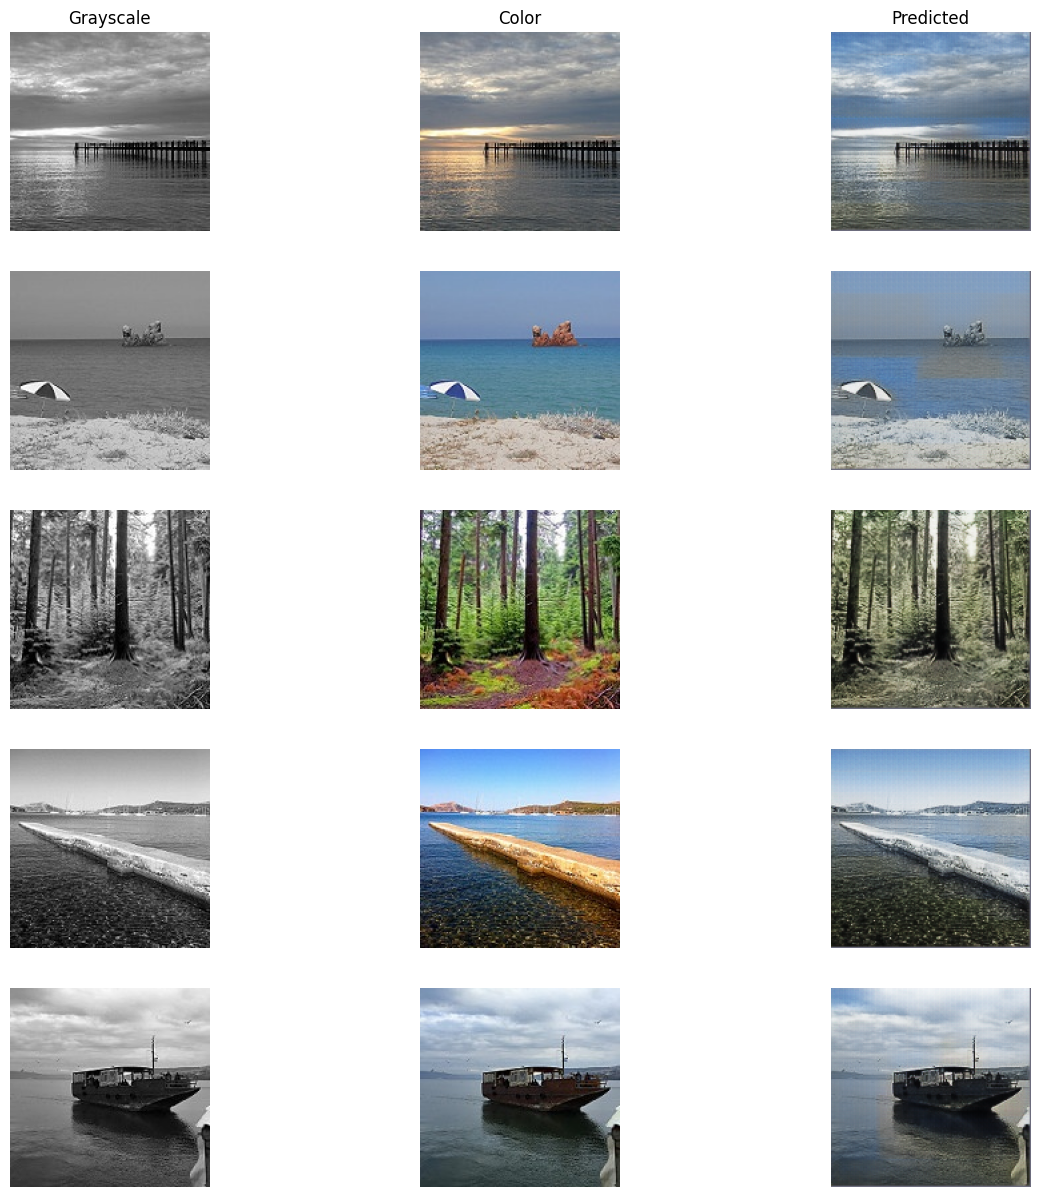

In [ ]:
show_predictions(color_img.detach().cpu(), gray_img.detach().cpu(), prediction.detach().cpu(), 5)

In [ ]:
torch.save(model.state_dict(), '/content/drive/MyDrive/Deep Learning/GreyToColor/colorization_model.pth')

In [ ]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(device)

cuda


<ipython-input-36-c841cd14c797>:10: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load('/content/drive/MyDrive/Deep Learning/GreyToColor/coloriza

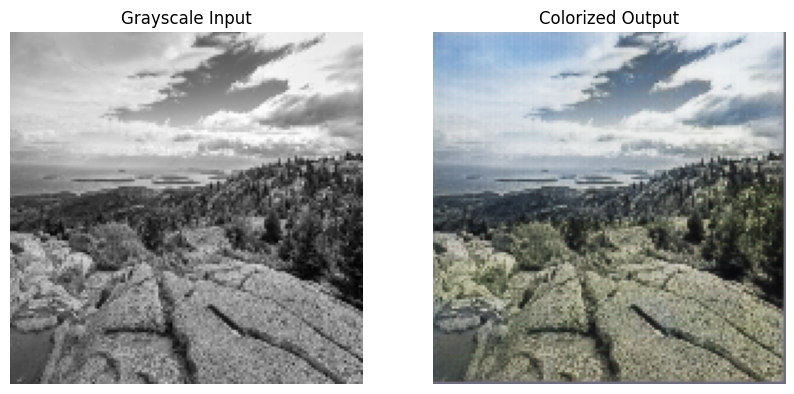

In [ ]:
# Load the saved model
model = ColorAutoEncoder().to(device)
model.load_state_dict(torch.load('/content/drive/MyDrive/Deep Learning/GreyToColor/colorization_model.pth'))
model.eval()

# Load and preprocess the image
image_path = '/content/istockphoto-1446618872-612x612.png'
input_image = read_image(image_path) / 255
transform = transforms.Compose([
    transforms.Resize((150, 150), antialias=False),
    transforms.Grayscale()
])
input_tensor = transform(input_image).unsqueeze(0).to(device)


# Make a prediction
with torch.no_grad():
    predicted_image = model(input_tensor)

# Display the original grayscale and the colorized image
plt.figure(figsize=(10, 5))
plt.subplot(1, 2, 1)
plt.title('Grayscale Input')
plt.imshow(input_tensor.squeeze().cpu(), cmap='gray')
plt.axis('off')

plt.subplot(1, 2, 2)
plt.title('Colorized Output')
plt.imshow(predicted_image.squeeze().permute(1, 2, 0).cpu())
plt.axis('off')

plt.show()